In [1]:
import scanpy as sc
import scvelo as scv
from cellrank.kernels import PrecomputedKernel
from cellrank.estimators import GPCCA
import numpy as np
import pandas as pd
from cellrank._utils._key import Key
import numpy as np
from scipy.sparse import diags
from scipy.stats import rankdata
import matplotlib.pyplot as plt

In [2]:
data_dir = "/home/chensishuo/spvelo/our_model/spavelo/logs/real_data/axolotl_1219_final/model/20251216-233705"
adata = sc.read_h5ad(f"{data_dir}/spavelo_adata.h5ad")
save_dir = f"{data_dir}/ptime_reverse2.svg"

In [3]:
adata

AnnData object with n_obs × n_vars = 4410 × 1805
    obs: 'CellID', 'index', 'CellID_ref', 'spatial_leiden_e30_s8', 'Batch', 'seurat_clusters', 'Annotation', 'Cluster', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'pass_basic_filter', 'pred_t', 'pred_velocity_self_transition', 'root_cells', 'end_points', 'pred_velocity_pseudotime', 'cell_latent_time'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'Gene', 'pass_basic_filter', 'use_for_dynamics', 'switch_pred'
    uns: 'Annotation_colors', 'Cluster_sizes', 'Stage57_telencephalon_rep2_DP8400015649BRD5_1', 'angle_dict', 'dynamics', 'latent_time_per_root', 'log1p', 'neighbors', 'paga', 'pca', 'pp', 'pred_velocity_graph', 'pred_velocity_graph_neg', 'pred_velocity_params', 'root_cells_cluster', 'state_order', 'vel_params_names'
    obsm: 'X_coord', 'X_coord_raw', 'X_pca', 'X_spatial', 'X_umap', 'latent_z', 'spatial'
    varm: 'PCs', 'alpha', 'alpha_1', 'beta', 'gamma', 'lambda_alpha', 'vel_param

In [4]:
scv.pp.neighbors(adata, use_rep="coord")
scv.tl.velocity_graph(adata, vkey="pred_velocity")

computing neighbors
    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/104 cores)


100%|██████████| 4410/4410 [00:08<00:00, 546.96cells/s]


    finished (0:00:08) --> added 
    'pred_velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [5]:
transition_matrix = scv.tl.transition_matrix(adata, vkey="pred_velocity", basis="umap")

In [6]:
adata.obsp["transition_matrix"] = transition_matrix
k = PrecomputedKernel(adata, None, obsp_key="transition_matrix")

In [7]:
g = GPCCA(k)

In [8]:
g.compute_eigendecomposition()

GPCCA[kernel=PrecomputedKernel[n=4410], initial_states=None, terminal_states=None]

In [9]:
print("eigengap suggested # of macro states =", g.eigendecomposition["eigengap"] + 1)
g.compute_macrostates(n_states=4, n_cells=None)
g.adata.obs["Annotation_fix"] = g.adata.obs["Cluster"].astype("category")
g._macrostates.assignment.index = g.adata.obs_names
n_states = g.eigendecomposition["eigengap"] + 1
g.predict_initial_states(n_states=n_states, allow_overlap=True)
g.predict_terminal_states(method="stability", stability_threshold=0.96, allow_overlap=True)

eigengap suggested # of macro states = 4


GPCCA[kernel=PrecomputedKernel[n=4410], initial_states=['0', '1'], terminal_states=['0', '1', '2', '3']]

In [10]:
trans_neigh_csr = adata.obsp['transition_matrix']
#term_cells = adata.obs[term_key].notna() 
trans_neigh_csr_bwd = trans_neigh_csr.T

In [11]:
def compute_velocity_pseudotime_reverse(T, term_cells, n_iter=100):
    n_cells = T.shape[0]
    x = np.zeros(n_cells)
    x[term_cells] = 1
    history = []
    
    for i in range(n_iter):
        x = T.dot(x)
        history.append(x.copy())
    
    history = np.array(history)
    pseudotime = history.sum(axis=0)
    
    sort_idx = np.argsort(pseudotime)
    rank = np.zeros_like(sort_idx, dtype=float)
    rank[sort_idx] = np.linspace(0, 1, len(sort_idx))
    rank = rank
    return rank

In [12]:
def compute_simple_diffusion_pseudotime(T, term_cells, 
                                        n_iter=100,
                                        alpha=0.1,
                                        normalization='rank'):
    n_cells = T.shape[0]
    
    row_sums = np.array(T.sum(axis=1)).flatten()
    row_sums[row_sums == 0] = 1
    D_inv = diags(1.0 / row_sums)
    T_norm = D_inv @ T
    
    x = np.zeros(n_cells, dtype=np.float64)
    x[term_cells] = 1.0
    
    history = []
    
    for i in range(n_iter):
        x = (1 - alpha) * x + alpha * (T_norm @ x)
        
        x[term_cells] = 1.0
        
        history.append(x.copy())
    
    history = np.array(history)
    
    pseudotime = history.sum(axis=0)
    
    if normalization == 'minmax':
        pseudotime = pseudotime - pseudotime.min()
        pseudotime = pseudotime / (pseudotime.max() + 1e-10)
        
    elif normalization == 'rank':
        ranks = rankdata(pseudotime, method='average')
        pseudotime = (ranks - 1) / (len(ranks) - 1)
    
    else:
        raise ValueError("normalization 必须是 'minmax' 或 'rank'")
    
    return pseudotime

macrostates_fwd
3    1329
2    1251
1     977
0     853
Name: count, dtype: int64


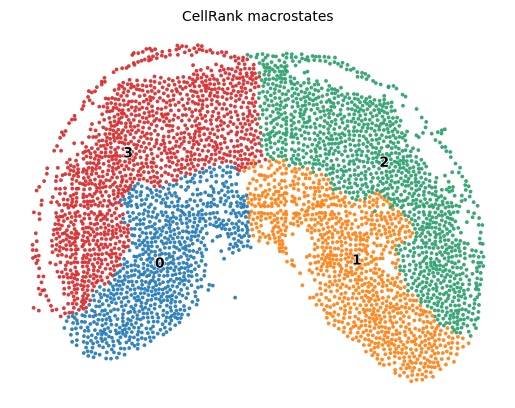

In [13]:
adata.obs['macrostates_fwd'] = g.macrostates.reindex(adata.obs_names)
print(adata.obs['macrostates_fwd'].value_counts(dropna=False))
macro_key = Key.obs.macrostates(g.backward)  # 'macrostates_fwd'
adata.uns[f"{macro_key}_colors"] = g._macrostates.colors
scv.pl.scatter(
    adata,
    basis="spatial",
    color=macro_key,
    legend_loc="on data",
    palette=adata.uns[f"{macro_key}_colors"],
    size=30, alpha=0.9,
    title="CellRank macrostates"
)

In [14]:
macro_counts = adata.obs['macrostates_fwd'].value_counts()
valid_states = macro_counts[macro_counts >= 0].index.tolist()
term_key = Key.obs.term_states(g.backward, bwd=False)
term_cells = (adata.obs[term_key].notna()) & (adata.obs[term_key].isin(valid_states))

In [15]:
adata.obs["ptime_reverse2"] = compute_velocity_pseudotime_reverse(trans_neigh_csr_bwd, term_cells)

<Axes: title={'center': 'ptime reverse2'}, xlabel='coord1', ylabel='coord2'>

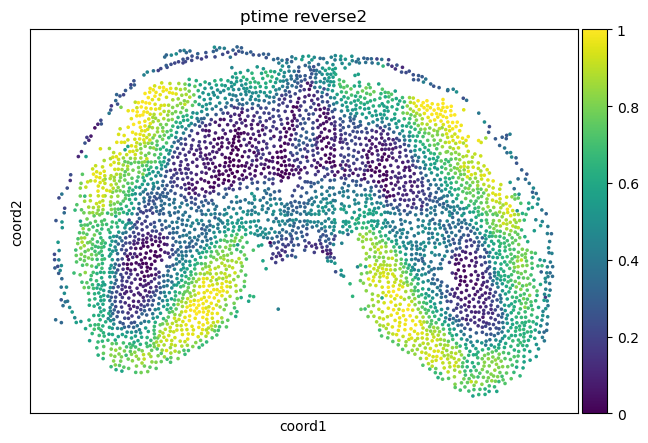

In [16]:
sc.pl.scatter(adata, basis="coord", color="ptime_reverse2", show=False)
# plt.savefig(f"{data_dir}/ptime_reverse2.svg")